In [20]:
import mne
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

## Reading XDF EEG data

In [1]:
from utilities import read_xdf

# For Interact-UI, recommended run in .py file.
raw = read_xdf("Pipo_1_5_test1.xdf", show_plot=False, show_psd=False) 

Creating RawArray with float64 data, n_channels=8, n_times=49650
    Range : 0 ... 49649 =      0.000 ...   198.521 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 75 samples (0.300 sec)



c:\Users\seami\OneDrive\Documents\GitHub\BCI-MNE-project\Offline\utilities.py:35: RuntimeWarning: The unit for channel(s) obci_eeg1_0 has changed from NA to V.
  raw.set_channel_types({'obci_eeg1_0': 'eeg'})   # FP1
c:\Users\seami\OneDrive\Documents\GitHub\BCI-MNE-project\Offline\utilities.py:36: RuntimeWarning: The unit for channel(s) obci_eeg1_1 has changed from NA to V.
  raw.set_channel_types({'obci_eeg1_1': 'eeg'})   # O1
c:\Users\seami\OneDrive\Documents\GitHub\BCI-MNE-project\Offline\utilities.py:37: RuntimeWarning: The unit for channel(s) obci_eeg1_2 has changed from NA to V.
  raw.set_channel_types({'obci_eeg1_2': 'eeg'})   # Oz
c:\Users\seami\OneDrive\Documents\GitHub\BCI-MNE-project\Offline\utilities.py:38: RuntimeWarning: The unit for channel(s) obci_eeg1_3 has changed from NA to V.
  raw.set_channel_types({'obci_eeg1_3': 'eeg'})   # O2
c:\Users\seami\OneDrive\Documents\GitHub\BCI-MNE-project\Offline\utilities.py:39: RuntimeWarning: The unit for channel(s) obci_eeg1_4 has c

### Plot show EEG data & PSD (overview)

Using matplotlib as 2D backend.


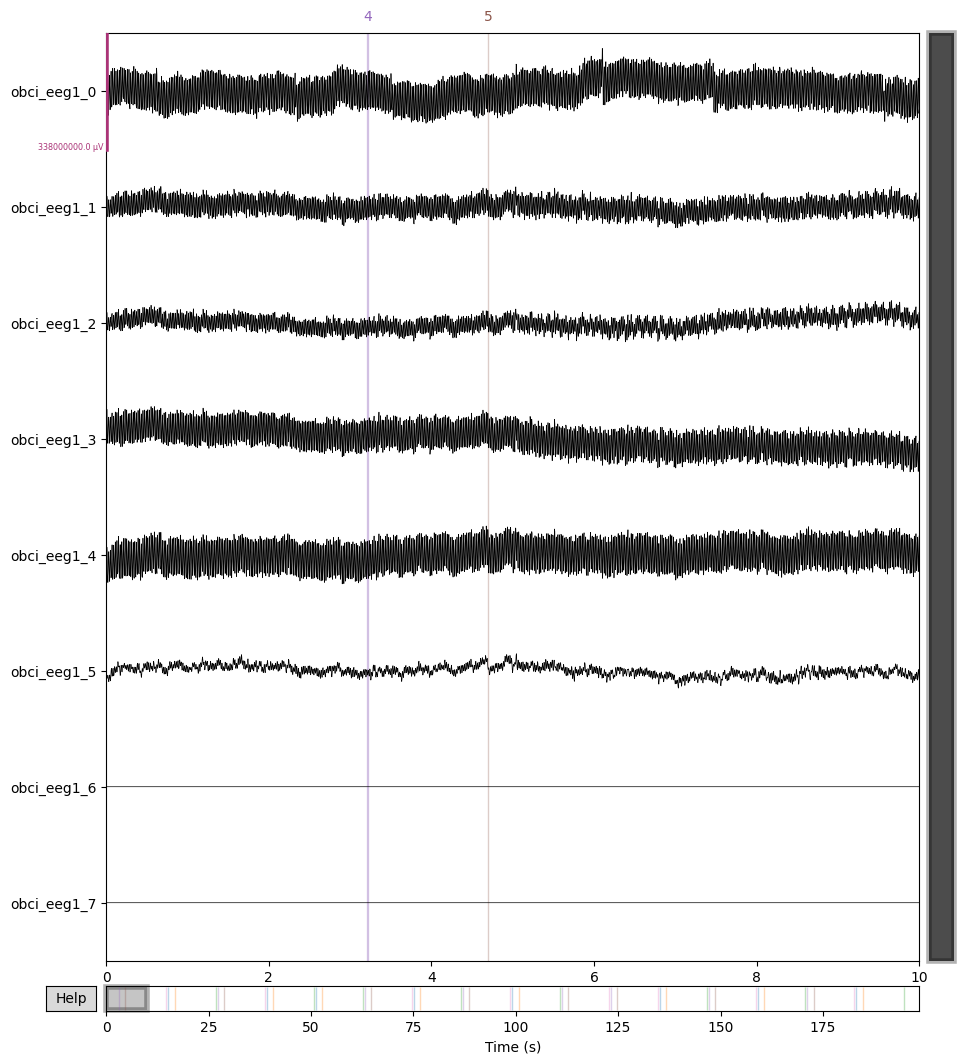

Effective window size : 1.024 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


C:\Users\seami\AppData\Local\Temp\ipykernel_9368\3413466856.py:6: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(
c:\Users\seami\AppData\Local\Programs\Python\Python39\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


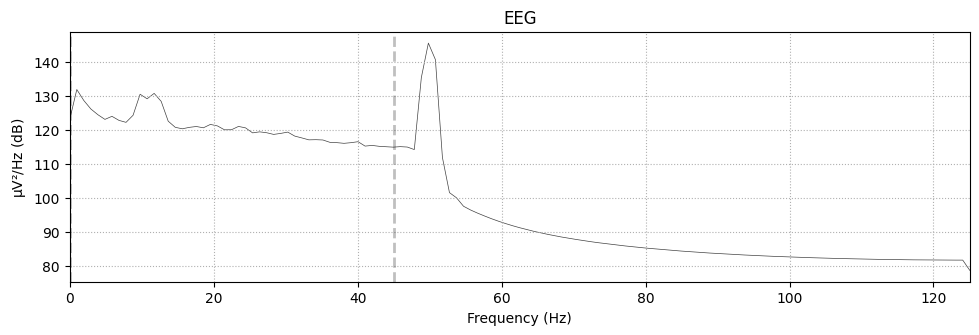

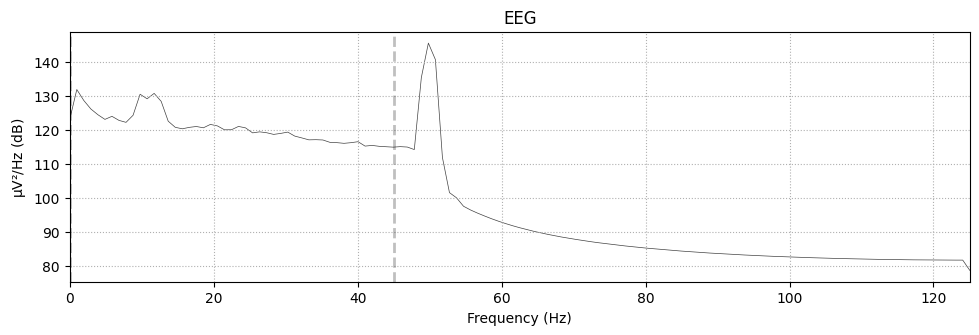

In [3]:
raw.plot(
    duration=10, 
    start=0.0, 
    scalings=169, # You may edit scalings value later
    )
raw.compute_psd(
    picks='obci_eeg1_1',    # pick by channel name
    # picks='eeg',          # pick by channel type
    ).plot()


### Bandpass Filtering

In [4]:
raw_bp = raw.copy().filter(l_freq=3.0, h_freq=15.0)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 3 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 3.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 2.00 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 413 samples (1.651 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Using matplotlib as 2D backend.


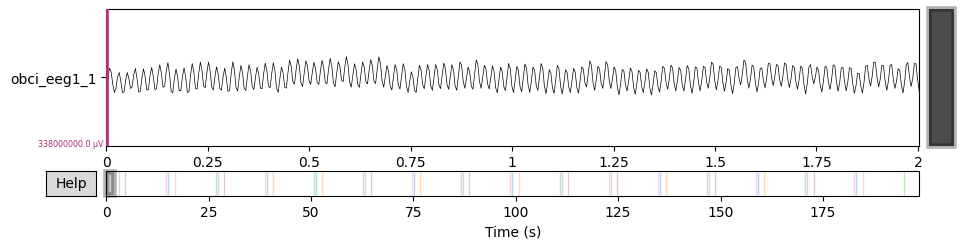

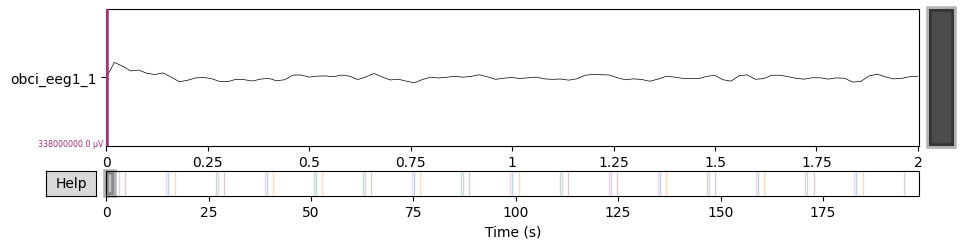

In [5]:
fig1 = raw.copy().pick('obci_eeg1_1').plot(
    duration=2, start=0.0, show=False,
    scalings=169, # You may edit scalings value later
    )
fig1.set_figheight(2); plt.show()

fig2 = raw_bp.copy().pick('obci_eeg1_1').plot(
    duration=2, start=0.0, show=False,
    scalings=169, # You may edit scalings value later
    )
fig2.set_figheight(2); plt.show()

### Event handle

In [8]:
print(raw.annotations)
# print(raw.annotations.onset[0])

<Annotations | 48 segments: 1 (8), 2 (8), 3 (8), 4 (8), 5 (8), 6 (8)>


**Our project event (annotations) types** (this information is not standardized)

1 : *Left cue start*

2 : *Left stimuli start*

3 : *Left blank start*

4 : *Right cue start*

5 : *Right stimuli start*

6 : *Right blank start*

In [9]:
annotations_des = {
    '1': 'Left cue start',
    '2': 'Left stimuli start',
    '3': 'Left blank start',
    '4': 'Right cue start',
    '5': 'Right stimuli start',
    '6': 'Right blank start',
}
raw_eeg = raw.pick_channels([ # Pick only O1, Oz, O2, POz, Pz
    'obci_eeg1_1', 'obci_eeg1_2', 'obci_eeg1_3', 'obci_eeg1_4', 'obci_eeg1_5'])
raw_eeg_bp = raw_bp.pick_channels([ # Pick only O1, Oz, O2, POz, Pz
    'obci_eeg1_1', 'obci_eeg1_2', 'obci_eeg1_3', 'obci_eeg1_4', 'obci_eeg1_5'])

# Read Event from annotations
events, event_dict = mne.events_from_annotations(raw_eeg)
print('Total events:', len(events))
# print(event_dict)
# print(events[:5])

Used Annotations descriptions: ['1', '2', '3', '4', '5', '6']
Total events: 48


## Epoching

In [10]:
# Split Epochs (Trials)
epochs = mne.Epochs(raw_eeg, events, 
        tmin=0,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax=10,    # final timestamp (10 means set epoch duration 10 second)
        baseline=(0, 0),
        preload=True,
    )
epochs_bp = mne.Epochs(raw_eeg_bp, events, 
        tmin=0,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax=10,    # final timestamp (10 means set epoch duration 10 second)
        baseline=(0, 0),
        preload=True,
    )

Not setting metadata
48 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 2502 original time points ...
1 bad epochs dropped
Not setting metadata
48 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 2502 original time points ...
1 bad epochs dropped


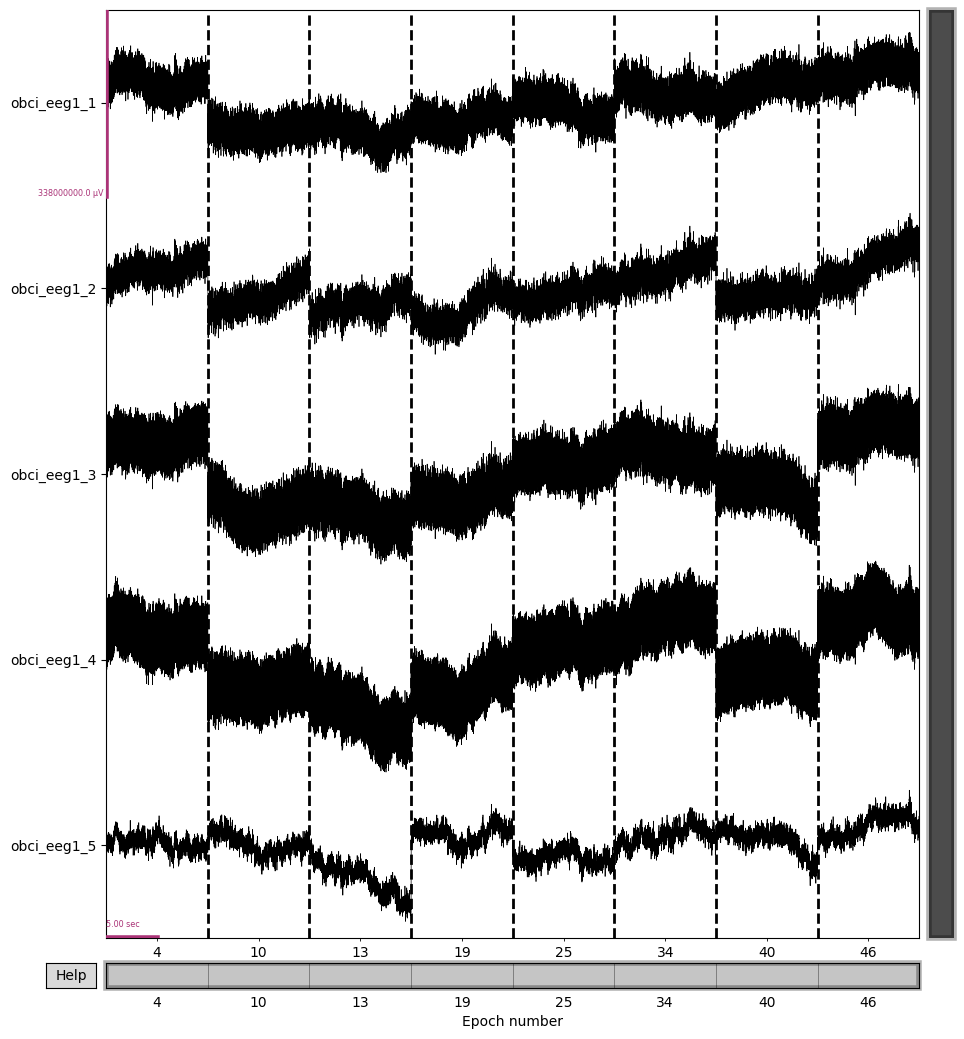

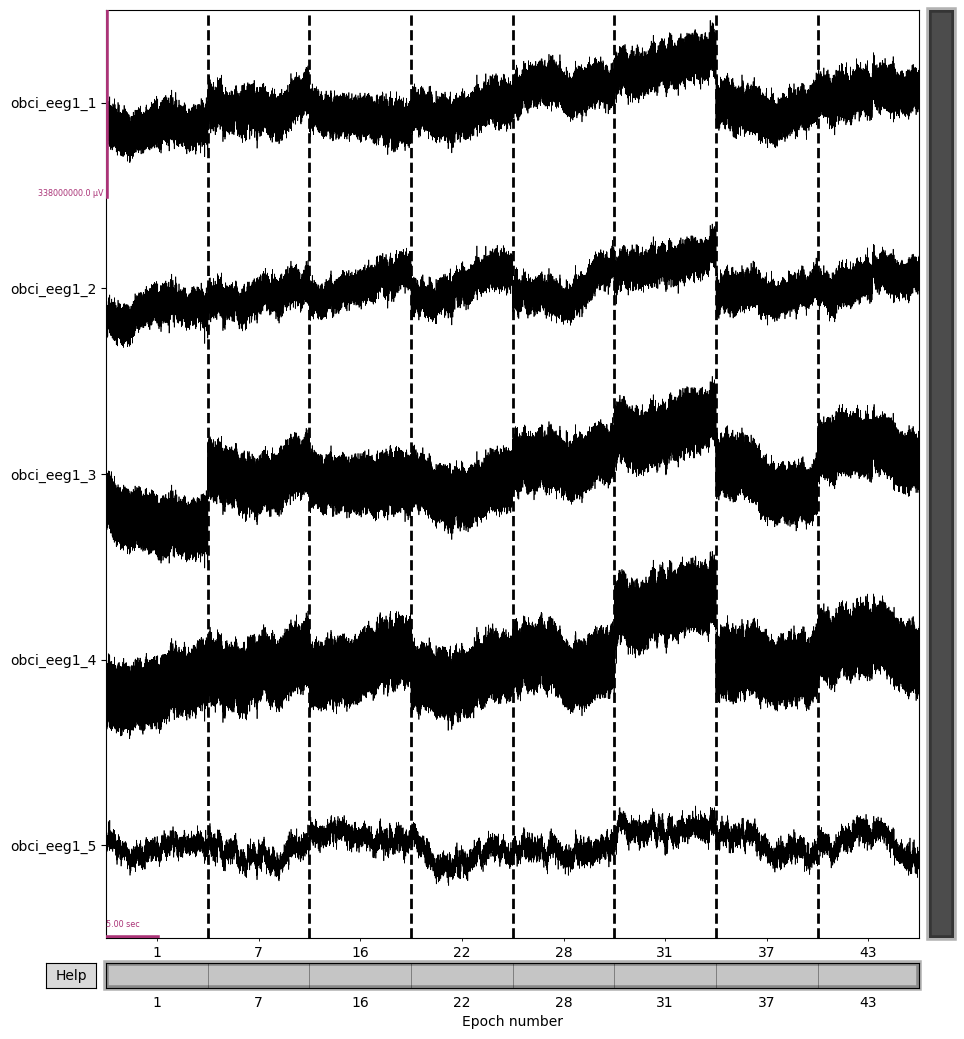

In [12]:
# Preview EEG split by epoch

# Select epoch (trial) of event '2' which is Left-stimuli
epochs['2'].plot(
    scalings=169, # You may edit scalings value later
    title='Left stimuli start',
)
# Select epoch (trial) of event '5' which is Right-stimuli
epochs['5'].plot(
    scalings=169, # You may edit scalings value later
    title='Right stimuli start',
)
plt.show()

### Plot PSD of Left-Right stimuli

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


C:\Users\seami\AppData\Local\Temp\ipykernel_14364\2294490277.py:7: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs['2'].compute_psd(
C:\Users\seami\AppData\Local\Temp\ipykernel_14364\2294490277.py:16: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs['5'].compute_psd(


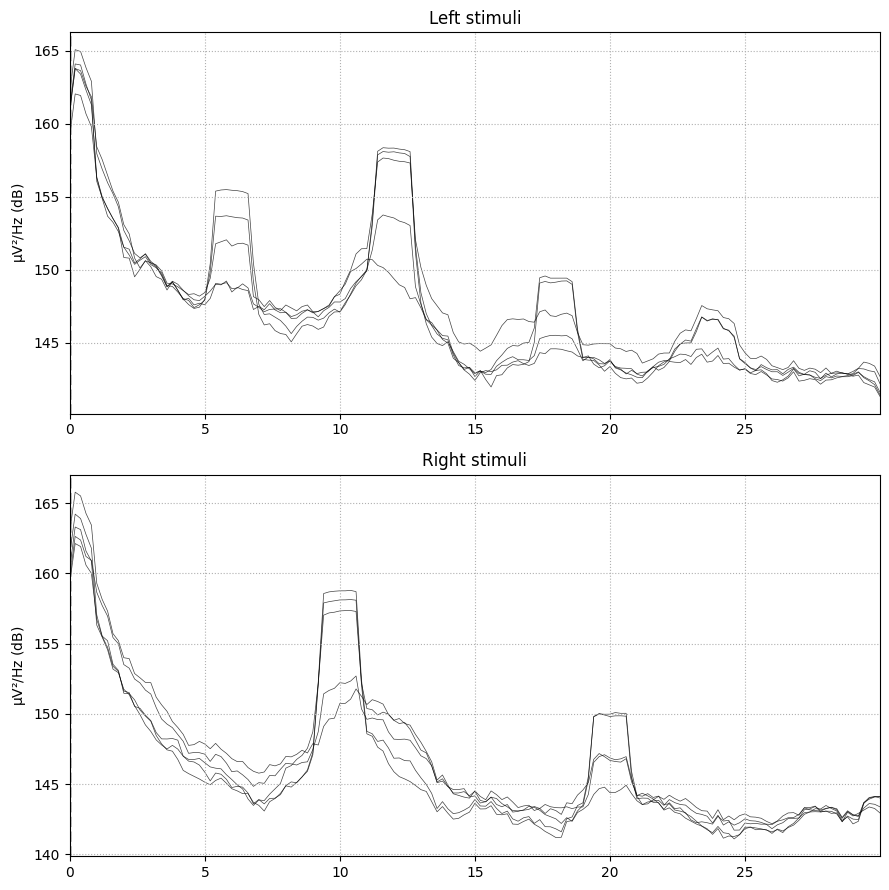

In [88]:
# from utilities import show_epoch
#
# show_epoch(raw)

fig, ax = plt.subplots(2, figsize=(9,9))

epochs['2'].compute_psd(
    # method='welch',
    fmax=30,                    
    ).plot(
        axes=ax[0],
        average=False,
        )
ax[0].set_title('Left stimuli')

epochs['5'].compute_psd(
    # method='welch',
    fmax=30,                    
    ).plot(
        axes=ax[1],
        average=False,
        )
ax[1].set_title('Right stimuli')

plt.tight_layout()
plt.show()

The Peak frequency of Left-stimuli is **6Hz**, 12Hz, 18Hz, ... (which is *Harmonic frequency*) and

the Peak frequency of Right-stimuli is **10Hz**, 20Hz, ... (which is *Harmonic frequency*)

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


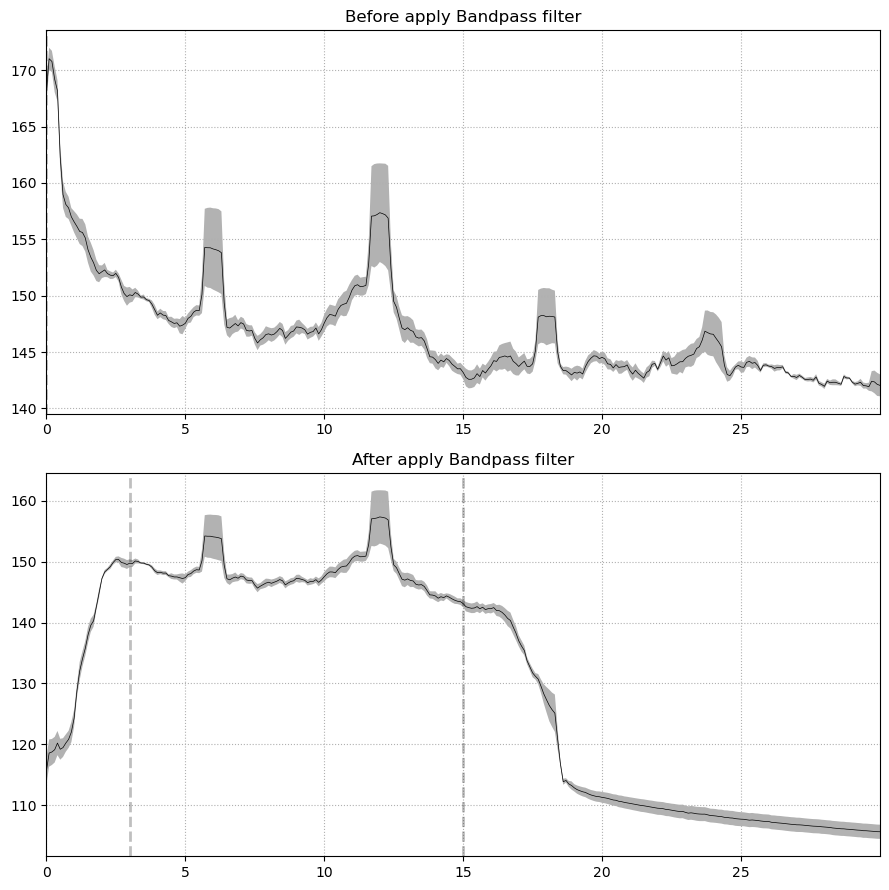

In [12]:
fig, ax = plt.subplots(2, figsize=(9,9))

epochs['2'].compute_psd(
    fmax=30,                    
    ).plot(
        axes=ax[0],
        average=True,
        )
ax[0].set_title('Before apply Bandpass filter')

# After Bandpass filtered
epochs_bp['2'].compute_psd(
    fmax=30,                    
    ).plot(
        axes=ax[1],
        average=True,
        )
ax[1].set_title('After apply Bandpass filter')

plt.tight_layout()
plt.show()

### Plot Time-frequency

In [ ]:
# Split Epochs (Trials) including Cue
epochs_from_cue = mne.Epochs(raw_eeg_bp, events, 
        tmin=-1.0,      # init timestamp of epoch (-1.0 means trigger before event start 1.0 second)
        tmax=10.0,      # final timestamp (10 means set epoch duration 10 second)
        # baseline=(0, 0),
        preload=True,
    )
channel_name = (    
    '(O1) obci_eeg1_1',
    '(Oz) obci_eeg1_2',
    '(O2) obci_eeg1_3',
    '(POz) obci_eeg1_4',
    '(Pz) obci_eeg1_5',)

fig, ax = plt.subplots(2, 5, figsize=(20, 8))
plt.title('Time-frequency')

# Select range of frequency you wanna plot
show_freqs = list(range(1,25))
# show_freqs = [6.0, 12.0, 18.0, 24.0, 10.0, 20.0, 30.0]

for i in range(5):
    power_L = mne.time_frequency.tfr_multitaper(
        epochs_from_cue['2'], 
        freqs=show_freqs, 
        n_cycles=10, 
        use_fft=True, 
        decim=3,
        return_itc=False,
    )
    power_L.plot([i], mode='logratio', axes=ax[0,i], show=False, colorbar=False)
    ax[0,i].set_title('Left stimuli - '+channel_name[i]); ax[0,i].set_xlabel('')

    power_R = mne.time_frequency.tfr_multitaper(
        epochs_from_cue['5'], 
        freqs=show_freqs, 
        n_cycles=10, 
        use_fft=True, 
        decim=3,
        return_itc=False,
    )
    power_R.plot([i], mode='logratio', axes=ax[1,i], show=False, colorbar=False)
    ax[1,i].set_title('Right stimuli - '+channel_name[i])

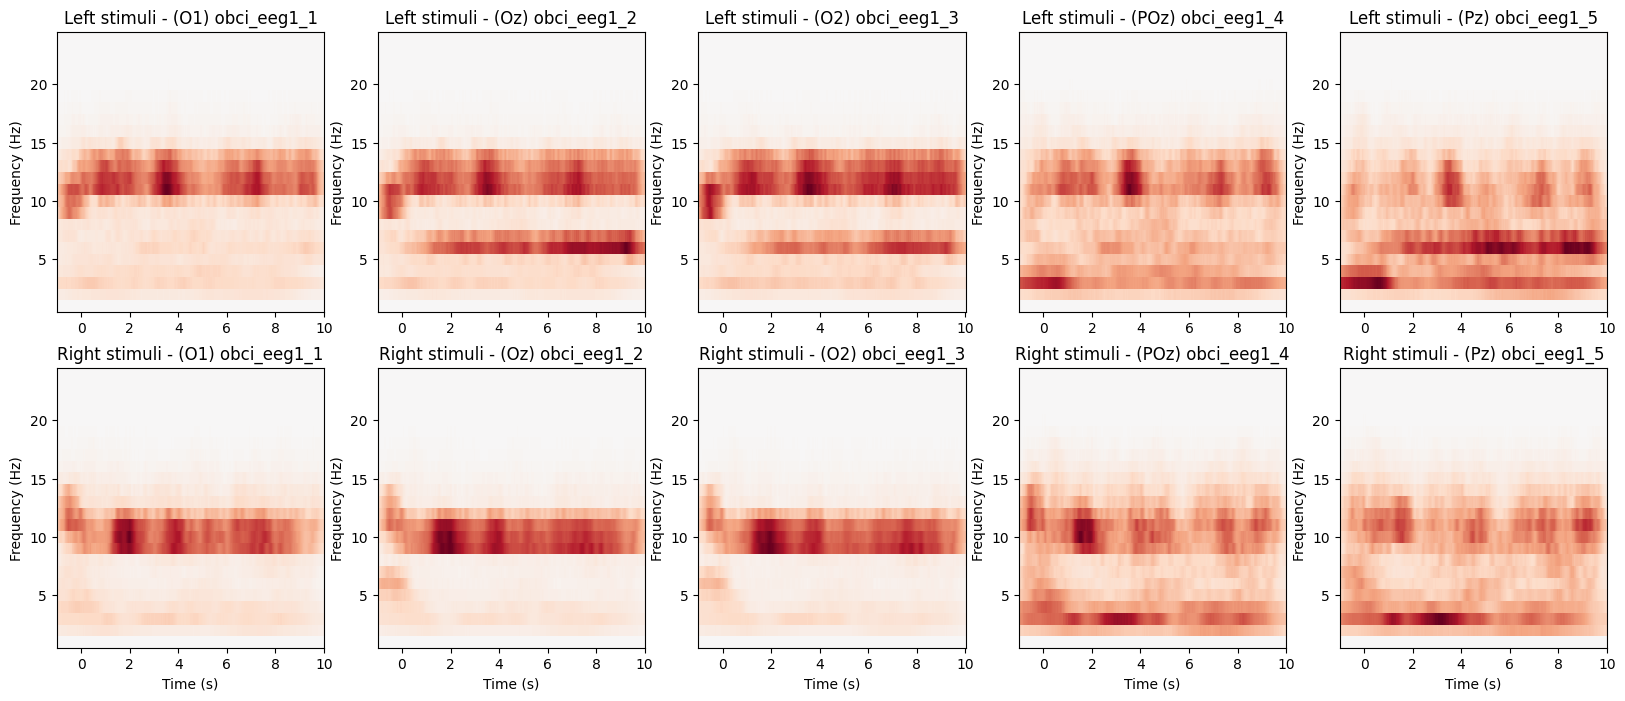

In [56]:
plt.show()

Found that when stimuli event start (at time=0) Frequency signal is very clear on **O1, Oz, O2** and kinda unclear on channel POz, Pz.

## Decoding

More idea 💡 [EEG Notebooks / SSVEP Decoding](https://neurotechx.github.io/eeg-notebooks/auto_examples/visual_ssvep/02r__ssvep_decoding.html)

#### Epoching

In [56]:
# Bandpass filter the raw data
raw_6Hz = raw_eeg.filter(l_freq=5.0, h_freq=7.0)
raw_10Hz = raw_eeg.filter(l_freq=9.0, h_freq=11.0)

# Concatenate with the bandpass filtered channels
raw_all = raw_6Hz.add_channels([raw_10Hz], force_update_info=True)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 8.00 Hz)
- Filter length: 413 samples (1.651 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 9 - 11 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 9.00
- Lower transition bandwidth: 2.25 Hz (-6 dB cutoff frequency: 7.88 Hz)
- Upper passband edge: 11.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


ValueError: The following channels are present in more than one input measurement info objects: ['obci_eeg1_2', 'obci_eeg1_5', 'obci_eeg1_1', 'obci_eeg1_4', 'obci_eeg1_3']

In [41]:
epochs = mne.Epochs(raw_all, events, 
        tmin=0,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax=5,     # final timestamp (5 means set epoch duration 5 second)
        baseline=(0, 0),
        preload=True,
    )
epochs.pick_types(eeg=True)
# Pick only event 2: Left stimuli, 5: Right stimuli
epochs = epochs['2','5']

Not setting metadata
48 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 1251 original time points ...
1 bad epochs dropped


Get the values as *numpy array*

In [83]:
X:np.ndarray = epochs.get_data() * 1e6
F:np.ndarray = epochs.compute_psd(method='welch', fmax=30).get_data()
t:np.ndarray = epochs.times
y:np.ndarray = epochs.events[:, -1]

Effective window size : 1.024 (s)


> **! Important** to use in Online task, performimg spectral analysis should use **`method='welch'`** which is Fast Fourier transform (default is `method='multitaper'`) 

In [102]:
X.shape, F.shape, t.shape, y.shape

((16, 5, 1251), (16, 5, 31), (1251,), (16,))

In [95]:
def simple_model(frequency_6Hz_Left, frequency_10Hz_Right, f_6Hz_threshold=3.0, f_10Hz_threshold=8.0) -> list:
    """
    This function classify the frequency of the 6Hz(Left) and 10Hz(Right) signals by giving threshold
    
    parameters
    ----------
    frequency_6Hz_Left <class 'list' or 'numpy.ndarray'>
    frequency_10Hz_Right <class 'list' or 'numpy.ndarray'>

    return
    ------
    outputs <class 'list'> ex. [5, 2, 2, 5, 2, ...]
    """
    if not isinstance(frequency_6Hz_Left, list):
        frequency_6Hz_Left, frequency_10Hz_Right = [frequency_6Hz_Left], [frequency_10Hz_Right]
    
    outputs = []

    for f6, f10 in zip(frequency_6Hz_Left, frequency_10Hz_Right):

        if f10 >= f_10Hz_threshold: outputs.append(5)
        elif f6 >= f_6Hz_threshold: outputs.append(2)
    
    return outputs

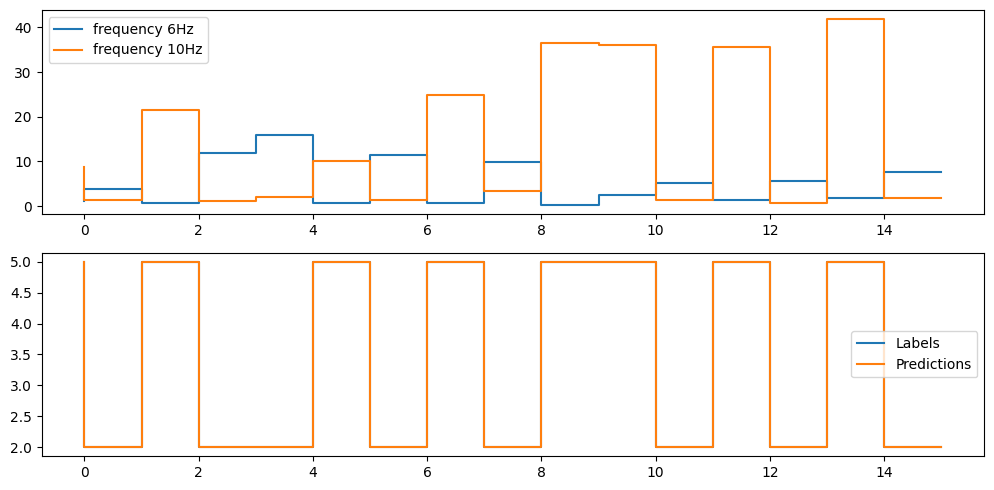

Labels     : [5, 2, 5, 2, 2, 5, 2, 5, 2, 5, 5, 2, 5, 2, 5, 2]
Predictions: [5, 2, 5, 2, 2, 5, 2, 5, 2, 5, 5, 2, 5, 2, 5, 2]


In [101]:
fig, ax = plt.subplots(2, figsize=(10, 5))
test_L, test_R, label, x = [], [], [], list(range(16))

for evnt in x:
    # print(y[evnt], F[evnt][0][6], F[evnt][0][10])
    # print()
    
    test_L.append(F[evnt][2][6])
    test_R.append(F[evnt][2][10])
    label.append(y[evnt])

ax[0].step(x, test_L)
ax[0].step(x, test_R)
ax[0].legend(['frequency 6Hz', 'frequency 10Hz'])

outputs = simple_model(test_L, test_R)

ax[1].step(x, label)
ax[1].step(x, outputs)
ax[1].legend(['Labels', 'Predictions'])

plt.tight_layout()
plt.show()

print('Labels     :', label)
print('Predictions:', outputs)

## Save bandpassed epochs of left and right stimuli for model training

In [ ]:
raw_bp1 = read_xdf('Pipo_1_5_test1.xdf', bandpass=(3, 15), show_plot=False, show_psd=False)
raw_bp2 = read_xdf('Pipo_1_5_test2.xdf', bandpass=(3, 15), show_plot=False, show_psd=False)
raw_bp3 = read_xdf('Pipo_1_5_test3.xdf', bandpass=(3, 15), show_plot=False, show_psd=False)

In [52]:
raw_eeg_bp1 = raw_bp1.pick_channels([ # Pick only O1, Oz, O2, POz, Pz
    'obci_eeg1_1', 'obci_eeg1_2', 'obci_eeg1_3', 'obci_eeg1_4', 'obci_eeg1_5'])
raw_eeg_bp2 = raw_bp2.pick_channels([ # Pick only O1, Oz, O2, POz, Pz
    'obci_eeg1_1', 'obci_eeg1_2', 'obci_eeg1_3', 'obci_eeg1_4', 'obci_eeg1_5'])
raw_eeg_bp3 = raw_bp3.pick_channels([ # Pick only O1, Oz, O2, POz, Pz
    'obci_eeg1_1', 'obci_eeg1_2', 'obci_eeg1_3', 'obci_eeg1_4', 'obci_eeg1_5'])

# Read Event from annotations
events1, event_dict1 = mne.events_from_annotations(raw_eeg_bp1)
events2, event_dict2 = mne.events_from_annotations(raw_eeg_bp2)
events3, event_dict3 = mne.events_from_annotations(raw_eeg_bp3)

Used Annotations descriptions: ['1', '2', '3', '4', '5', '6']
Used Annotations descriptions: ['1', '2', '3', '4', '5', '6']
Used Annotations descriptions: ['1', '2', '3', '4', '5', '6']


In [53]:
epochs_bp1 = mne.Epochs(raw_eeg_bp1, events1, 
        tmin=0,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax=10,    # final timestamp (10 means set epoch duration 10 second)
        baseline=(0, 0),
        preload=True,
    )
epochs_bp2 = mne.Epochs(raw_eeg_bp2, events2,
        tmin=0,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax=10,    # final timestamp (10 means set epoch duration 10 second)
        baseline=(0, 0),
        preload=True,
    )
epochs_bp3 = mne.Epochs(raw_eeg_bp3, events3,
        tmin=0,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax=10,    # final timestamp (10 means set epoch duration 10 second)
        baseline=(0, 0),
        preload=True,
    )

Not setting metadata
48 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 2502 original time points ...
1 bad epochs dropped
Not setting metadata
48 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 2502 original time points ...
0 bad epochs dropped
Not setting metadata
48 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 2502 original time points ...
1 bad epochs dropped


In [54]:
leftDF1 = epochs_bp1['2'].to_data_frame()
leftDF1['label'] = 'left'
rightDF1 = epochs_bp1['5'].to_data_frame()
rightDF1['label'] = 'right'

leftDF2 = epochs_bp2['2'].to_data_frame()
leftDF2['label'] = 'left'
rightDF2 = epochs_bp2['5'].to_data_frame()
rightDF2['label'] = 'right'

leftDF3 = epochs_bp3['2'].to_data_frame()
leftDF3['label'] = 'left'
rightDF3 = epochs_bp3['5'].to_data_frame()
rightDF3['label'] = 'right'

In [55]:
df = pd.concat([leftDF1, leftDF2, leftDF3, rightDF1, rightDF2, rightDF3])
df = df.reset_index(drop=True)
df

,time,condition,epoch,obci_eeg1_1,obci_eeg1_2,obci_eeg1_3,obci_eeg1_4,obci_eeg1_5,label
0,0.000000,2,4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,left
1,0.003998,2,4,9.560825e+05,1.066537e+06,-3.564930e+05,8.029332e+05,1.072216e+06,left
2,0.007997,2,4,1.750024e+06,2.040599e+06,-6.392410e+05,1.462844e+06,1.849889e+06,left
3,0.011995,2,4,2.326237e+06,2.912548e+06,-7.483269e+05,1.967236e+06,2.293789e+06,left
4,0.015994,2,4,2.672258e+06,3.688852e+06,-5.930081e+05,2.340968e+06,2.415026e+06,left
...,...,...,...,...,...,...,...,...,...
120091,9.983941,5,46,-1.029854e+07,-1.761795e+06,7.075701e+05,-3.084194e+06,1.114025e+06,right
120092,9.987939,5,46,-1.052954e+07,-1.922865e+06,1.043126e+06,-3.588589e+06,-4.216151e+05,right
120093,9.991938,5,46,-1.084775e+07,-2.410654e+06,1.058603e+06,-4.084717e+06,-1.801493e+06,right
120094,9.995936,5,46,-1.130992e+07,-3.268248e+06,6.924690e+05,-4.634310e+06,-2.982314e+06,right


In [56]:
if not os.path.exists('data'):
    os.makedirs('data')
df.to_csv('data/epochs.csv', index=False)